** Mohamed ALLILI & Sabrina CHAOUCHE **

Mohamed ALLILI & Sabrina CHAOUCHE

## Partie 1 - Description du problème

Se baser sur les caractéristiques des joueurs (leurs attributs)  afin de calculer des scores, puis faire des prédictions sur les matchs <b>(équipe gagnante, équipe perdante, match nul).</b>
<ol>
<li>Scores global pour chaque joueur.</li>
<li>Scores global pour chaque équipe (sur une période).</li>
</ol>
<br>
Une fois ces scores calculés (train). Pour un match donné (predict), on calcule un score pour l'équipe <b>home</b> et l'équipe <b>away</b> puis les comparer pour prédire.




## Partie 2 - Modèle

On construit un classifier (<b>PlayerPrediction</b>) qu'on entraine sur un ensemble de matchs et un ensemble de joueurs. Et qui fait la prédiction sur un match donné.<br>
Pour plus d'efficacité, on construit un autre classifier (<b>PlayerPredictionAgg</b>) qu'on entraine sur un ensemble de <b>PlayerPredictions</b>. Et pour la prédiction, on prends la classe majoritaire des classes retournées par les predicts des <b>PlayerPredictions</b>.
<br>
<br>
<b> Pour PlayerPrediction : </b>
<br>
<ul>
    <li>
    Durant le train on calcule les scores suivant :
        <ol>
        <li>Score pour chaque joueur (moyenne de l'attribut potentiel). 
        $Score_{joueur} = \frac{1}{N} \sum_{i=1}^{N}Potentiel_{joueur}[i] $ </li>
        <li>Score pour chaque équipe (moyenne des scores de ses joueurs). 
        $Score_{equipe} = \frac{1}{N} \sum_{i=1}^{N}Score_{joueur}[i] $ </li>
        </ol>
    </li>
    
    <li>
    Pour un match donné, pour prédire le résultat (match nul, vainqueur, perdant), on calcule un score pour chaque équipe (home et away) qui est : <br> 
    $Score_{equipe}^{match} = Score_{equipe} \times \frac{1}{11} \sum_{i=1}^{11}Potentiel_{joueur\_sur\_le\_terrain}[i] $  
    Puis, on les compare pour retourner un résultat :
    <ul>
        <li>--> 1 : match nul</li>
        <li>--> 2 : equipe home a gagné</li>
        <li>--> -2 : equipe home a perdu</li>
    </ul>
    
</ul>
<br>
Pour <b>PlayerPredictionAgg : </b><br>
On l'entraine sur un ensemle de <b>PlayerPredictions</b> qui sont entrainés chacun sur les matchs <b>d'une saison</b>.<br>
Et pour la prédiction, on prends la classe majoritaire des classes retournées par les predicts des <b>PlayerPredictions</b>.
<br>
<br>

## Partie 3 - Code

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
"""
Variables importantes :
    * data_player : données de la table player
    * data_playerattributes : données de la table playerattributes
    * data_team : données de la table team
    * data_teamattributes : données de la table teamattributes
    * data_match : données de la table match
    * data_country : données de la table country
    
    * countries : liste des pays
    * leagues : liste des ligues (championnats)
    ----> dans la table match il y a une seule ligue par pays
    * seasons : liste des différentes saisons
    * player_potentiel : le potentiel de chaque joueur (moyenne)
    * columns_player_home : nom des colonnes pour les IDs des joueurs home dans match
    * columns_player_away : nom des colonnes pour les IDs des joueurs away dans match
    * columns_team_match : nom des colonnes utiles à garder (équipes, buts, saison, date ...)
    * data_match_players : DataFrame de data_match avec les colonnes columns_player_home, columns_player_away. \
                            En supprimant les lignes avec des valeurs nulles (car s'il manque un joueur le score de \
                            l'équipe qu'on calcule n'est pas fiable).
                            
    * data_match_players_N : Tout les matchs de la saison N/N+1
    * date_sep : permet de récupérer des matchs avant la date, et après la date (elle change de valeur à chaque fois)
    * data_match_players_N_train : Tout les matchs de la saison N/N+1 qui ont eu lieu avant 'date_sep'
    * data_match_players_N_test : Tout les matchs de la saison N/N+1 qui ont eu lieu après 'date_sep'
    * data_match_player_year : collection(liste) de tout les matchs où chaque element correspond à data_match_players_N
    * data_match_players_train : collection(liste) de matchs où chaque element correspond à data_match_players_N_train
    * data_match_players_test : collection(liste) de matchs où chaque element correspond à data_match_players_N_test
    * data_match_players_avant_N : Tout les matchs avant la saison N/N+1
    * data_match_players_apres_N : Tout les matchs apres la saison N/N+1
"""
print()

In [3]:
def moyenne(liste): 
    """calcul de la moyenne des valeurs de liste"""
    if (liste!= []): 
        return float(sum(liste)) / len(liste)
    else:
        return None

def moyenne_dict_val(dic):
    """calcul de la moyenne des valeurs du dictionnaire dic"""
    liste_tmp = list()
    for k,v in dic:
        liste_tmp.append(v)
    return moyenne(liste_tmp)


In [4]:
def get_match_season(data, season, _id=None):
    """
    data : ensemble de matchs
    season : une saison donnée (ex: 2008/2009)
    _id : id d'un pays
    ---> la fonction retourn tout les matchs de la saison 'season' si _id n'est pas donné \
            sinon les matchs de la saison 'season' du pays d'id=_id  
    """
    if _id != None:
        match_season = data.groupby("season").get_group(season)
        match_season_pays = match_season.groupby("country_id").get_group(_id)
        #on les trie
        match_season_pays = match_season_pays.sort_values(by=['date'], inplace=False)
        return match_season_pays
    else:        
        match_season = data.groupby("season").get_group(season)
        #on les trie
        match_season = match_season.sort_values(by=['date'], inplace=False)
        return match_season
    

In [5]:
def get_equipes_tmp(_data_match):
    """
    _data_match : ensemble de matchs
    retourne toutes les équipes avec leurs joueurs (qui se trouvent dans '_data_match')
    """
    ligne, colonne = _data_match.shape
    equipes_tmp = dict()
    for i in range(ligne):
        equipes_tmp[ _data_match['home_team_api_id'].iloc[i] ] = set()
        equipes_tmp[ _data_match['away_team_api_id'].iloc[i] ] = set()
    for i in range(ligne):
        for c in columns_player_home:
            equipes_tmp[_data_match['home_team_api_id'].iloc[i]].add(_data_match[c].iloc[i])
        for c in columns_player_away:
            equipes_tmp[_data_match['away_team_api_id'].iloc[i]].add(_data_match[c].iloc[i])

    for i in range(ligne):
        equipes_tmp[ _data_match['home_team_api_id'].iloc[i] ] = list(equipes_tmp[ _data_match['home_team_api_id'].iloc[i] ])
        equipes_tmp[ _data_match['away_team_api_id'].iloc[i] ] = list(equipes_tmp[ _data_match['away_team_api_id'].iloc[i] ])
        
    return equipes_tmp

In [6]:
def get_potentiel_joueur_date(data, date):
    """
    data : un ensemble de données de la table playerattributes
    date : une date
    --> la fonction retourne le potentiel moyen de chaque joueur (moyenne des potentiels des matchs avant 'date') 
    """
    tmp = data[['player_api_id', "date", 'potential']]
    tmp = tmp.loc[tmp['date'] < date]
    tmp = tmp.dropna(inplace=False)
    return tmp.groupby('player_api_id').mean()['potential']

In [7]:
def classe_majoritaire(LabeledSet, classes):
    """
    LabeledSet : un ensemble de données 
    classes : ensemble de classes
    la fonction retourne la classes majoritaire (parmi les classe de 'classes') des données présentes dans 'LabeledSet'
    """
    dict_size = dict()
    for c in classes:
        dict_size[c] = 0
    for i in range(len(classes)):
        dict_size[ classes[i] ] = len(LabeledSet.y[np.where(LabeledSet.y==classes[i])])
    classe = classes[0]
    classe_max = 0
    for k,v in dict_size.items():
        if c > classe_max:
            classe_max = v
            classe = k
    return classe

In [8]:
def toDataSet(data):
    """
    data : un DataFrame
    crée un LabeledSet 'labeledSet' à partir du DataFrame 'data' en attribuant les classes suivantes:\
                        * 1 : pour les matchs nuls
                        * 2 : pour les matchs gagnés par l'équipe home
                        * -2 : pour les matchs gagnés par l'équipe away
    """
    labeledSet = LabeledSet(1)
    for i in range (data.shape[0]):
        row = data.iloc[i]
        but1 = row['home_team_goal']
        but2 = row['away_team_goal']
        if but1>but2:
            labeledSet.addExample(row, 2)
        elif but2>but1:
            labeledSet.addExample(row, -2)
        else:
            labeledSet.addExample(row, 1)
    return labeledSet


In [9]:
def plot2DSet(set):
    """ LabeledSet -> NoneType
        Hypothèse: set est de dimension 2
        affiche une représentation graphique du LabeledSet
        remarque: l'ordre des labels dans set peut être quelconque
    """
    x = np.array(set.x)
    S_home = x[np.where(set.y == 2),:][0]      # tous les exemples de label +2 
    S_away = x[np.where(set.y == -2),:][0]     # tous les exemples de label -2
    S_draw = x[np.where(set.y == 1),:][0]      # tous les exemples de label 1
    plt.scatter(S_home[:,0],S_home[:,1],marker='o')
    plt.scatter(S_away[:,0],S_away[:,1],marker='x')
    plt.scatter(S_draw[:,0],S_draw[:,1],marker='+')
    plt.xlabel("home")
    plt.ylabel("away")

In [10]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            #self.x = np.array([vector])
            self.x = [vector]
            self.y = np.array([label])
        else:
            #self.x = np.vstack((self.x, vector))
            self.x.append(vector)
            self.y = np.vstack((self.y, label))
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return(self.y[i])

In [11]:
class Classifier:
    def __init__(self,input_dimension):
        """ Constructeur """
        raise NotImplementedError("Please Implement this method")
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    # Permet d'entrainer le modele sur un ensemble de données étiquetés
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    # Permet de calculer le taux de bonne classification
    def accuracy(self,set):
        nb_ok=0
        for i in range(set.size()):
            score = self.predict(set.getX(i))
            if (score*set.getY(i)>0):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc


In [12]:
class PlayerPrediction(Classifier):
    def __init__(self,dimension, egalite=0.05):
        self.dimension = dimension
        self.egalite = egalite
        self.potentiel_player = {}
        self.potentiel_team = {}
        self.result_match = LabeledSet(2)

    #Permet de calculer la prediction sur un match
    def predict(self, match):
        row = match
        eq1 = row["home_team_api_id"]
        players_1 = list( row[columns_player_home] )
        eq2 = row["away_team_api_id"]
        players_2 = list( row[columns_player_away] )
        pot_eq1 = 0
        pot_eq2 = 0
        for i in range(len(players_1)):
            pot_eq1 += self.potentiel_player[players_1[i]]
            pot_eq2 += self.potentiel_player[players_2[i]]
        pot_eq1 = pot_eq1*1.0/len(players_1)
        pot_eq2 = pot_eq2*1.0/len(players_2)
        #on verifie si on s'est entrainé sur les 2 equipes
        if self.potentiel_team.get(eq1, -1)==-1 or self.potentiel_team.get(eq2, -1)==-1:
            return 0
        score1 = self.potentiel_team[eq1] * pot_eq1
        score2 = self.potentiel_team[eq2] * pot_eq2
        score1 *= 1.0/(100*100)
        score2 *= 1.0/(100*100)
        #score1 = pot_eq1
        #score2 = pot_eq2
        diff = np.abs(score1-score2)
        if diff<self.egalite: 
            #match nul
            #print("egalite score1={0}, score2={1}, difference de {2} avec epsilon={3}".format(score1, score2, diff, self.egalite))
            self.result_match.addExample([score1, score2], 1)
            return 1
        elif score1 > score2:
            # victoire home
            self.result_match.addExample([score1, score2], 2)
            return 2
        else:
            # victoire away
            self.result_match.addExample([score1, score2], -2)
            return -2
    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, data_matchs, player_pot):
        for k,v in player_pot.items():
            self.potentiel_player[k] = v
        self.equipes = get_equipes_tmp(data_matchs)
        for k, v in self.equipes.items():
            somme = 0
            for player in v:
                somme += self.potentiel_player[player]
            moy = somme*1.0 / len(v)
            self.potentiel_team[k] = moy
        self.data_matchs = data_matchs
        
        
    def accuracy(self,dataset):
        nb_ok=0
        for i in range(dataset.size()):
            #df_tmp = pd.DataFrame(dataset.getX(i).reshape(-1, len(dataset.getX(i))), columns=self.data_matchs.columns)
            score = self.predict(dataset.getX(i))
            if (score*dataset.getY(i)==1): #match nul pour le modele et nul en vrai
                nb_ok = nb_ok+1
            elif (score*dataset.getY(i) > 0):
                nb_ok = nb_ok+1
        acc = nb_ok/(dataset.size() * 1.0)
        return acc
        
    
    

In [13]:
class PlayerPredictionAgg(Classifier):
    def __init__(self,dimension, egalite=0.05):
        self.dimension = dimension
        self.egalite = egalite
    #Permet de calculer la prediction sur un match
    def predict(self, match):
        res_predictionClassifierYear = LabeledSet(self.dimension)
        for i in range(len(self.predictionClassifierYear)):
            res_tmp = self.predictionClassifierYear[i].predict(match)
            res_predictionClassifierYear.addExample(i , res_tmp)
        return classe_majoritaire(res_predictionClassifierYear, [1, 2, -2])
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, predictionClassifierYear):
        self.predictionClassifierYear = predictionClassifierYear
        
    def accuracy(self,dataset):
        nb_ok=0
        for i in range(dataset.size()):
            #df_tmp = pd.DataFrame(dataset.getX(i).reshape(-1, len(dataset.getX(i))), columns=self.data_matchs.columns)
            score = self.predict(dataset.getX(i))
            if (score*dataset.getY(i)==1): #match nul pour le modele et nul en vrai
                nb_ok = nb_ok+1
            elif (score*dataset.getY(i) > 0):
                nb_ok = nb_ok+1
        acc = nb_ok/(dataset.size() * 1.0)
        return acc

## Partie 4 - Protocole expérimental

In [14]:
data_player = pd.read_csv("soccer_csv/player.csv")
data_playerattributes = pd.read_csv("soccer_csv/playerattributes.csv")

In [15]:
data_playerattributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [16]:
player_potentiel = data_playerattributes.groupby('player_api_id').mean()['potential']
#player_potentiel = data_playerattributes.loc[data_playerattributes["date"]<'2008'].groupby('player_api_id')['potential'].mean()
player_potentiel.head()

player_api_id
2625    61.142857
2752    70.380952
2768    70.571429
2770    73.533333
2790    75.800000
Name: potential, dtype: float64

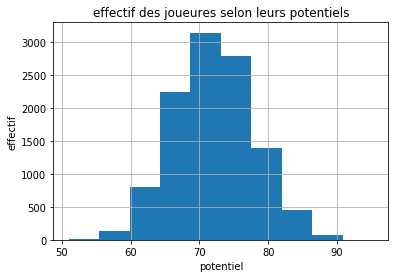

In [17]:
player_potentiel.hist()
plt.title("effectif des joueures selon leurs potentiels")
plt.xlabel("potentiel")
plt.ylabel("effectif")
plt.show()

In [18]:
data_country = pd.read_csv("soccer_csv/country.csv")

In [19]:
data_team = pd.read_csv("soccer_csv/team.csv")
data_teamattributes = pd.read_csv("soccer_csv/teamattributes.csv")

In [20]:
data_teamattributes.groupby("buildUpPlaySpeedClass").count()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
buildUpPlaySpeedClass,,,,,,,,,,,,,,,,,,,,,
Balanced,1184,1184,1184,1184,1184,430,1184,1184,1184,1184,...,1184,1184,1184,1184,1184,1184,1184,1184,1184,1184
Fast,172,172,172,172,172,50,172,172,172,172,...,172,172,172,172,172,172,172,172,172,172
Slow,102,102,102,102,102,9,102,102,102,102,...,102,102,102,102,102,102,102,102,102,102


In [21]:
data_match = pd.read_csv("soccer_csv/match.csv")

In [22]:
data_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [23]:
data_match.tail()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,25979,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992095,10192,9931,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
print("les colonnes de match")
for i in range(len(data_match.columns)):
    print(data_match.columns[i], end="', '")

les colonnes de match
id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_play

In [25]:
countries = data_match["country_id"].unique()
leagues = data_match["league_id"].unique()

print(countries)
print(leagues)


[    1  1729  4769  7809 10257 13274 15722 17642 19694 21518 24558]
[    1  1729  4769  7809 10257 13274 15722 17642 19694 21518 24558]


In [26]:
seasons = data_match['season'].unique()
print(seasons)

['2008/2009' '2009/2010' '2010/2011' '2011/2012' '2012/2013' '2013/2014'
 '2014/2015' '2015/2016']


In [27]:
# On récupère les noms des colonnes des joueurs de chaque équipe
columns_player_home = list()
columns_player_away = list()
ind = 55
while ind < 55+11 :
    columns_player_home.append(data_match.columns[ind])
    ind += 1
while ind < 55+11+11 :
    columns_player_away.append(data_match.columns[ind])
    ind += 1


columns_team_match = ['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']
# On crée un DataFrame contenant  les ids des joueurs des 2 équipes et le score, les equipes ...
data_match_players = pd.DataFrame(data_match[columns_team_match+columns_player_home+columns_player_away])
# On supprime les lignes ayant des valeurs null (NaN)
data_match_players.dropna(inplace=True)
data_match_players.head()

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
145,2009-02-27 00:00:00,493017,8203,9987,2,1,38327.0,67950.0,67958.0,67959.0,...,38293.0,148313.0,104411.0,148314.0,37202.0,43158.0,9307.0,42153.0,32690.0,38782.0
153,2009-03-08 00:00:00,493025,9984,8342,1,3,36835.0,37047.0,37021.0,37051.0,...,21812.0,11736.0,37858.0,38366.0,37983.0,39578.0,38336.0,52280.0,27423.0,38440.0
155,2009-03-07 00:00:00,493027,8635,10000,2,0,34480.0,38388.0,26458.0,13423.0,...,37886.0,37903.0,37889.0,94030.0,37893.0,37981.0,131531.0,130027.0,38231.0,131530.0
162,2009-03-13 00:00:00,493034,8203,8635,2,1,38327.0,67950.0,67958.0,38801.0,...,38388.0,38389.0,31316.0,164694.0,30949.0,38378.0,38383.0,38393.0,38253.0,37069.0
168,2009-03-14 00:00:00,493040,10000,9999,0,0,37900.0,37886.0,37100.0,37903.0,...,38247.0,16387.0,94288.0,94284.0,45832.0,26669.0,33671.0,163670.0,37945.0,33622.0


In [28]:
# verification que tous les joueurs de tous les matchs on un potentiel dans player_potentiel
print("verification que tous les joueurs de tous les matchs on un potentiel dans player_potentiel")
for k in columns_player_home+columns_player_away:
    for i in data_match_players[k]:
        if -1==player_potentiel.get(i, -1):
            print("Potentiel inexistant pour le joueur ", i)
print("fin ")

verification que tous les joueurs de tous les matchs on un potentiel dans player_potentiel
fin 


In [29]:
equipes = get_equipes_tmp(data_match_players)
equipes

{1601: [488960.0,
  555650.0,
  118530.0,
  69254.0,
  116872.0,
  115724.0,
  68877.0,
  178702.0,
  459662.0,
  33807.0,
  178196.0,
  465568.0,
  275751.0,
  168232.0,
  72489.0,
  138159.0,
  154928.0,
  277936.0,
  68786.0,
  275765.0,
  105526.0,
  282168.0,
  68802.0,
  30275.0,
  463810.0,
  30278.0,
  393287.0,
  13390.0,
  68732.0,
  306522.0,
  306523.0,
  294490.0,
  13405.0,
  433627.0,
  69346.0,
  309868.0,
  287341.0,
  69619.0,
  502645.0,
  502648.0,
  206844.0],
 1773: [287232.0,
  164229.0,
  38791.0,
  280968.0,
  38793.0,
  364813.0,
  45840.0,
  38800.0,
  68114.0,
  318615.0,
  39578.0,
  186918.0,
  39335.0,
  419238.0,
  45865.0,
  409000.0,
  120110.0,
  38323.0,
  149173.0,
  178486.0,
  78902.0,
  37051.0,
  98368.0,
  181569.0,
  37953.0,
  15938.0,
  256198.0,
  179783.0,
  11336.0,
  280134.0,
  181066.0,
  37963.0,
  131404.0,
  131408.0,
  277840.0,
  105680.0,
  94419.0,
  24149.0,
  197848.0,
  37981.0,
  26078.0,
  148829.0,
  303202.0,
  37993.0,
 

In [30]:
data_match_players_2008 = get_match_season(data_match, "2008/2009")
#recuperer que les colonne qui nous interessent
data_match_players_2008 = pd.DataFrame(data_match_players_2008[columns_team_match+columns_player_home+columns_player_away])
#supprimer les lignes avec des valeurs null
data_match_players_2008.dropna(inplace=True)
data_match_players_2008

,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
4776,2008-08-09 00:00:00,483137,9874,9855,1,2,26359.0,147351.0,26345.0,26328.0,...,41302.0,26027.0,32755.0,46709.0,31037.0,93480.0,5217.0,26285.0,33599.0,103482.0
4774,2008-08-09 00:00:00,483135,8481,8639,0,0,26233.0,111909.0,31684.0,94313.0,...,26107.0,26149.0,77741.0,26154.0,26291.0,26160.0,20401.0,32575.0,35407.0,26156.0
4773,2008-08-09 00:00:00,483134,9829,9847,1,0,145039.0,41097.0,26216.0,39199.0,...,20482.0,94043.0,26357.0,30457.0,30695.0,35499.0,32578.0,32572.0,37554.0,26312.0
4777,2008-08-09 00:00:00,483138,9873,9853,1,0,41301.0,26157.0,40016.0,41315.0,...,26148.0,26354.0,33813.0,37241.0,26419.0,41176.0,26353.0,25496.0,40988.0,25661.0
4770,2008-08-09 00:00:00,483131,9746,9831,1,0,41186.0,71607.0,38111.0,46447.0,...,26356.0,41121.0,26304.0,41019.0,30908.0,41122.0,26325.0,39987.0,94318.0,38108.0
4769,2008-08-09 00:00:00,483130,9827,7819,2,1,30458.0,32571.0,38703.0,40543.0,...,11324.0,26412.0,46338.0,11327.0,26420.0,26191.0,11329.0,18913.0,35410.0,46261.0
19695,2008-08-09 00:00:00,489983,8597,10251,1,0,32693.0,32694.0,32717.0,32700.0,...,32969.0,112123.0,32786.0,32622.0,24024.0,23987.0,41226.0,39107.0,32627.0,32706.0
19694,2008-08-09 00:00:00,489982,9860,9927,3,2,23445.0,34471.0,37307.0,32581.0,...,32833.0,43246.0,32844.0,35502.0,32830.0,23083.0,39659.0,37294.0,23728.0,32829.0
4772,2008-08-10 00:00:00,483133,9748,9941,3,0,26295.0,26162.0,37553.0,34320.0,...,26402.0,26253.0,26403.0,26401.0,26326.0,26406.0,24122.0,40103.0,41365.0,38098.0
19697,2008-08-10 00:00:00,489985,9925,9800,1,0,30974.0,33792.0,41071.0,41060.0,...,23446.0,23720.0,32968.0,35612.0,32975.0,33915.0,25128.0,47190.0,32978.0,34237.0


In [31]:
data_match_players_2008 = get_match_season(data_match, "2008/2009")
data_match_players_2008 = pd.DataFrame(data_match_players_2008[columns_team_match+columns_player_home+columns_player_away])
data_match_players_2008.dropna(inplace=True)

data_match_players_2009 = get_match_season(data_match, "2009/2010")
data_match_players_2009 = pd.DataFrame(data_match_players_2009[columns_team_match+columns_player_home+columns_player_away])
data_match_players_2009.dropna(inplace=True)

data_match_players_2010 = get_match_season(data_match, "2010/2011")
data_match_players_2010 = pd.DataFrame(data_match_players_2010[columns_team_match+columns_player_home+columns_player_away])
data_match_players_2010.dropna(inplace=True)

data_match_players_2011 = get_match_season(data_match, "2011/2012")
data_match_players_2011 = pd.DataFrame(data_match_players_2011[columns_team_match+columns_player_home+columns_player_away])
data_match_players_2011.dropna(inplace=True)

data_match_players_2012 = get_match_season(data_match, "2012/2013")
data_match_players_2012 = pd.DataFrame(data_match_players_2012[columns_team_match+columns_player_home+columns_player_away])
data_match_players_2012.dropna(inplace=True)

data_match_players_2013 = get_match_season(data_match, "2013/2014")
data_match_players_2013 = pd.DataFrame(data_match_players_2013[columns_team_match+columns_player_home+columns_player_away])
data_match_players_2013.dropna(inplace=True)

data_match_players_2014 = get_match_season(data_match, "2014/2015")
data_match_players_2014 = pd.DataFrame(data_match_players_2014[columns_team_match+columns_player_home+columns_player_away])
data_match_players_2014.dropna(inplace=True)

data_match_players_2015 = get_match_season(data_match, "2015/2016")
data_match_players_2015 = pd.DataFrame(data_match_players_2015[columns_team_match+columns_player_home+columns_player_away])
data_match_players_2015.dropna(inplace=True)


date_sep = "2009-04-01"
data_match_players_2008_train = data_match_players_2008.loc[data_match_players_2008["date"] < date_sep ]
data_match_players_2008_test = data_match_players_2008.loc[data_match_players_2008["date"] >= date_sep ]
date_sep = "2010-04-01"
data_match_players_2009_train = data_match_players_2009.loc[data_match_players_2009["date"] < date_sep ]
data_match_players_2009_test = data_match_players_2009.loc[data_match_players_2009["date"] >= date_sep ]
date_sep = "2011-04-01"
data_match_players_2010_train = data_match_players_2010.loc[data_match_players_2010["date"] < date_sep ]
data_match_players_2010_test = data_match_players_2010.loc[data_match_players_2010["date"] >= date_sep ]
date_sep = "2012-04-01"
data_match_players_2011_train = data_match_players_2011.loc[data_match_players_2011["date"] < date_sep ]
data_match_players_2011_test = data_match_players_2011.loc[data_match_players_2011["date"] >= date_sep ]
date_sep = "2013-04-01"
data_match_players_2012_train = data_match_players_2012.loc[data_match_players_2012["date"] < date_sep ]
data_match_players_2012_test = data_match_players_2012.loc[data_match_players_2012["date"] >= date_sep ]
date_sep = "2014-04-01"
data_match_players_2013_train = data_match_players_2013.loc[data_match_players_2013["date"] < date_sep ]
data_match_players_2013_test = data_match_players_2013.loc[data_match_players_2013["date"] >= date_sep ]
date_sep = "2015-04-01"
data_match_players_2014_train = data_match_players_2014.loc[data_match_players_2014["date"] < date_sep ]
data_match_players_2014_test = data_match_players_2014.loc[data_match_players_2014["date"] >= date_sep ]
date_sep = "2016-04-01"
data_match_players_2015_train = data_match_players_2015.loc[data_match_players_2015["date"] < date_sep ]
data_match_players_2015_test = data_match_players_2015.loc[data_match_players_2015["date"] >= date_sep ]

In [32]:
data_match_player_year = [
    data_match_players_2008,
    data_match_players_2009,
    data_match_players_2010,
    data_match_players_2011,
    data_match_players_2012,
    data_match_players_2013,
    data_match_players_2014,
    data_match_players_2015    
]
data_match_players_train = [
    data_match_players_2008_train,
    data_match_players_2009_train,
    data_match_players_2010_train,
    data_match_players_2011_train,
    data_match_players_2012_train,
    data_match_players_2013_train,
    data_match_players_2014_train,
    data_match_players_2015_train
]

data_match_players_test = [
    data_match_players_2008_test,
    data_match_players_2009_test,
    data_match_players_2010_test,
    data_match_players_2011_test,
    data_match_players_2012_test,
    data_match_players_2013_test,
    data_match_players_2014_test,
    data_match_players_2015_test
]

In [33]:
player_prediction = PlayerPrediction(1)
print("PlayerPrediction : train sur les matchs 2008/2009 avant Avril")
potentiel_joueur = get_potentiel_joueur_date(data_playerattributes, "2009-04")
player_prediction.train(data_match_players_2008_train,potentiel_joueur)
print("PlayerPrediction Accuracy : test sur les matchs 2008/2009 après Avril")
print("accuracy : ", player_prediction.accuracy(toDataSet(data_match_players_2008_test)), "\n")

#for i in range(data_match_players_2008_test.shape[0]):
#    match = data_match_players_2008_test.iloc[i]
#    res = player_prediction.predict(match)
#    print("score : ", match['home_team_goal'],"-", match['away_team_goal'], " --> ", res)


PlayerPrediction : train sur les matchs 2008/2009 avant Avril
PlayerPrediction Accuracy : test sur les matchs 2008/2009 après Avril
accuracy :  0.6912751677852349 



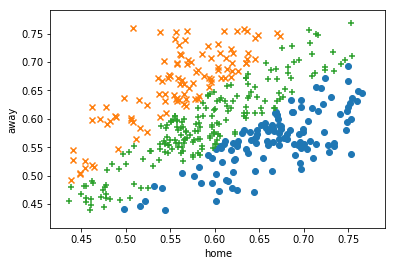

In [34]:
plot2DSet(player_prediction.result_match)

PlayerPrediction : train sur les matchs 2009/2010 avant Avril
PlayerPrediction Accuracy : test sur les matchs 2009/2010 après Avril
accuracy :  0.713963963963964


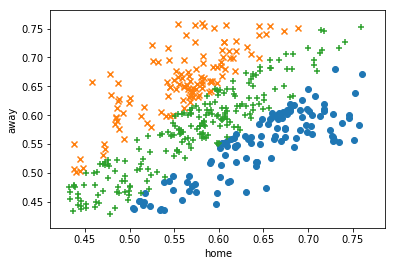

In [35]:
player_prediction2 = PlayerPrediction(1)
print("PlayerPrediction : train sur les matchs 2009/2010 avant Avril")
potentiel_joueur = get_potentiel_joueur_date(data_playerattributes, "2010-04")
player_prediction2.train(data_match_players_2009_train,potentiel_joueur)
print("PlayerPrediction Accuracy : test sur les matchs 2009/2010 après Avril")
print("accuracy : ", player_prediction2.accuracy(toDataSet(data_match_players_2009_test)))
plot2DSet(player_prediction2.result_match)

In [36]:
player_prediction = PlayerPrediction(1)
print("PlayerPrediction : train sur les matchs 2009/2010")
potentiel_joueur = get_potentiel_joueur_date(data_playerattributes, "2010-07")
player_prediction.train(data_match_players_2009,player_potentiel)
print("PlayerPrediction Accuracy : test sur les matchs 2010/2011")
print("accuracy : ", player_prediction.accuracy(toDataSet(data_match_players_2010)))

PlayerPrediction : train sur les matchs 2009/2010
PlayerPrediction Accuracy : test sur les matchs 2010/2011
accuracy :  0.5572065378900446


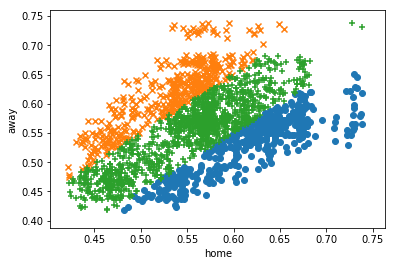

In [37]:
plot2DSet(player_prediction.result_match)

In [38]:
list_accuracy_annee = list()
for i in range(8):
    player_prediction = PlayerPrediction(1, 0.05)
    potentiel_joueur = get_potentiel_joueur_date(data_playerattributes, str(2008+1+i)+"-07")
    player_prediction.train(data_match_players_train[i],potentiel_joueur)
    dataSet = toDataSet(data_match_players_test[i])
    res_tmp = player_prediction.accuracy(dataSet)
    print("PlayerPrediction : accuracy pour la saison ", 2008+i,"/",2008+1+i, " : ", res_tmp)
    list_accuracy_annee.append(res_tmp)

PlayerPrediction : accuracy pour la saison  2008 / 2009  :  0.6912751677852349
PlayerPrediction : accuracy pour la saison  2009 / 2010  :  0.713963963963964
PlayerPrediction : accuracy pour la saison  2010 / 2011  :  0.69449378330373
PlayerPrediction : accuracy pour la saison  2011 / 2012  :  0.6962962962962963
PlayerPrediction : accuracy pour la saison  2012 / 2013  :  0.6888489208633094
PlayerPrediction : accuracy pour la saison  2013 / 2014  :  0.7081632653061225
PlayerPrediction : accuracy pour la saison  2014 / 2015  :  0.69377990430622
PlayerPrediction : accuracy pour la saison  2015 / 2016  :  0.7150635208711433


In [39]:
date_sep = "2014-07-01"
data_match_players_avant_2014 = data_match_players.loc[data_match_players["date"] < date_sep]
data_match_players_apres_2014 = data_match_players.loc[data_match_players["date"] >=date_sep]
player_prediction = PlayerPrediction(1)
print("PlayerPrediction : train sur les matchs avant 2014/2015")
potentiel_joueur = get_potentiel_joueur_date(data_playerattributes, "2014-07")
player_prediction.train(data_match_players_avant_2014,potentiel_joueur)
print("PlayerPrediction Accuracy : test sur les matchs après 2014/2015")
print("accuracy : ", player_prediction.accuracy(toDataSet(data_match_players_apres_2014)))


PlayerPrediction : train sur les matchs avant 2014/2015
PlayerPrediction Accuracy : test sur les matchs après 2014/2015
accuracy :  0.6057676279379897


In [40]:
liste_PlayerPrediction = list()
for i in range(6): #2008 à 2014
    player_prediction = PlayerPrediction(1, 0.05)
    potentiel_joueur = get_potentiel_joueur_date(data_playerattributes, str(2008+1+i)+"-07")
    player_prediction.train(data_match_player_year[i], potentiel_joueur)
    liste_PlayerPrediction.append(player_prediction)

In [41]:
player_prediction_agg = PlayerPredictionAgg(1)    
print("PlayerPredictionAgg : train sur les PlayerPredictions qui se sont entrainé chacun sur une saison \n sur les matchs avant 2014/2015")
player_prediction_agg.train(liste_PlayerPrediction)

PlayerPredictionAgg : train sur les PlayerPredictions qui se sont entrainé chacun sur une saison 
 sur les matchs avant 2014/2015


In [42]:
print("PlayerPredictionAgg Accuracy : test sur les matchs après 2014/2015")
print("accuracy : ", player_prediction_agg.accuracy(toDataSet(data_match_players_apres_2014)))

PlayerPredictionAgg Accuracy : test sur les matchs après 2014/2015
accuracy :  0.6977829638273045


In [43]:
countries = data_match["country_id"].unique()
leagues = data_match["league_id"].unique()
print("Les IDS des pays : ", countries)
print("Les IDs des ligues : ", leagues)
#Récuperér de data_match les matchs de chaque championnat
print("Récuperér de data_match les matchs de chaque championnat")
data_championnats = list()
for i in range(len(countries)):
    d_tmp = data_match.groupby("league_id").get_group(countries[i])
    d_tmp = d_tmp[['season']+columns_team_match+columns_player_home+columns_player_away]
    d_tmp = d_tmp.dropna(inplace=False)
    data_championnats.append( d_tmp )
print("fin")

Les IDS des pays :  [    1  1729  4769  7809 10257 13274 15722 17642 19694 21518 24558]
Les IDs des ligues :  [    1  1729  4769  7809 10257 13274 15722 17642 19694 21518 24558]
Récuperér de data_match les matchs de chaque championnat
fin


In [44]:
date_sep = "2014-07-01"
liste_accuracy_championnat = list()
liste_country = list()
print("PlayerPrediction : train sur les matchs avant ",date_sep, ", test sur les matchs d'après")
for i in range(len(data_championnats)):
    data_match_championnat_avant_2014 = data_championnats[i].loc[data_championnats[i]["date"] < date_sep]
    data_match_championnat_apres_2014 = data_championnats[i].loc[data_championnats[i]["date"] >=date_sep]
    player_prediction = PlayerPrediction(1)
    potentiel_joueur = get_potentiel_joueur_date(data_playerattributes, date_sep[0: len(date_sep)-3])
    player_prediction.train(data_match_championnat_avant_2014, potentiel_joueur)
    res_tmp = player_prediction.accuracy(toDataSet(data_match_championnat_apres_2014))
    liste_accuracy_championnat.append(res_tmp)
    pays = data_country.loc[ data_country["id"] == countries[i] ]["name"].iloc[0]
    liste_country.append( pays )
    print("* PlayerPrediction : accuracy pour le pays : ", pays, " : ", res_tmp)

PlayerPrediction : train sur les matchs avant  2014-07-01 , test sur les matchs d'après
* PlayerPrediction : accuracy pour le pays :  Belgium  :  0.618510158013544
* PlayerPrediction : accuracy pour le pays :  England  :  0.5641711229946524
* PlayerPrediction : accuracy pour le pays :  France  :  0.6204481792717087
* PlayerPrediction : accuracy pour le pays :  Germany  :  0.5849673202614379
* PlayerPrediction : accuracy pour le pays :  Italy  :  0.5699558173784978
* PlayerPrediction : accuracy pour le pays :  Netherlands  :  0.6929824561403509
* PlayerPrediction : accuracy pour le pays :  Poland  :  0.513677811550152
* PlayerPrediction : accuracy pour le pays :  Portugal  :  0.6122881355932204
* PlayerPrediction : accuracy pour le pays :  Scotland  :  0.6498740554156172
* PlayerPrediction : accuracy pour le pays :  Spain  :  0.593006993006993
* PlayerPrediction : accuracy pour le pays :  Switzerland  :  0.671875


In [45]:
date_sep = "2014-07-01"
liste_accuracy_championnat_agg = list()
liste_country_agg = list()
for i in range(len(data_championnats)):
    liste_PlayerPrediction = list()
    for j in range(6): #2008 à 2014
        data_ch = data_championnats[i].loc[data_championnats[i]["season"] == seasons[j]]
        player_prediction = PlayerPrediction(1, 0.05)
        #player_prediction.train(data_match_player_year[i], player_potentiel)
        potentiel_joueur = get_potentiel_joueur_date(data_playerattributes, date_sep[0: len(date_sep)-3])
        player_prediction.train(data_ch, potentiel_joueur)
        liste_PlayerPrediction.append(player_prediction)
    player_prediction_agg = PlayerPredictionAgg(1)    
    pays = data_country.loc[ data_country["id"] == countries[i] ]["name"].iloc[0]
    print("* \n PlayerPredictionAgg : train sur les PlayerPredictions qui se sont entrainé chacun sur une saison sur les matchs avant 2014/2015 pour le pays : ", pays)
    player_prediction_agg.train(liste_PlayerPrediction)
    d1 = data_championnats[i].loc[data_championnats[i]["season"] == seasons[6]]
    d2 = data_championnats[i].loc[data_championnats[i]["season"] == seasons[7]]
    frames = [d1, d2]
    data_match_players_apres_2014 = pd.concat(frames)
    res_tmp = player_prediction_agg.accuracy(toDataSet(data_match_players_apres_2014))
    liste_accuracy_championnat_agg.append(res_tmp)
    print("PlayerPredictionAgg : accuracy pour le pays ", pays," : ", res_tmp)
    liste_country_agg.append( pays )

* 
 PlayerPredictionAgg : train sur les PlayerPredictions qui se sont entrainé chacun sur une saison sur les matchs avant 2014/2015 pour le pays :  Belgium
PlayerPredictionAgg : accuracy pour le pays  Belgium  :  0.6997742663656885
* 
 PlayerPredictionAgg : train sur les PlayerPredictions qui se sont entrainé chacun sur une saison sur les matchs avant 2014/2015 pour le pays :  England
PlayerPredictionAgg : accuracy pour le pays  England  :  0.6951871657754011
* 
 PlayerPredictionAgg : train sur les PlayerPredictions qui se sont entrainé chacun sur une saison sur les matchs avant 2014/2015 pour le pays :  France
PlayerPredictionAgg : accuracy pour le pays  France  :  0.7086834733893558
* 
 PlayerPredictionAgg : train sur les PlayerPredictions qui se sont entrainé chacun sur une saison sur les matchs avant 2014/2015 pour le pays :  Germany
PlayerPredictionAgg : accuracy pour le pays  Germany  :  0.7075163398692811
* 
 PlayerPredictionAgg : train sur les PlayerPredictions qui se sont entr

## Partie 5 - Résultats

Accuracy du classifier <b>PlayerPrediction</b> par saison.<br>
* train sur les matchs avant Avril de chaque saison
* Test sur les matchs après Avril de chaque saison

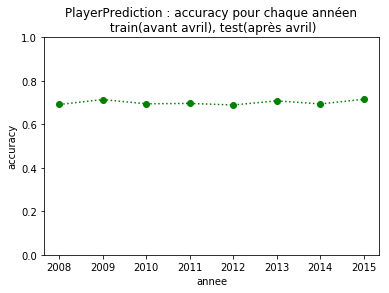

accuracy moyenne :  0.7002356028370026


In [46]:
plt.plot(list(range(2008, 2008+8)), list_accuracy_annee, "b:o", color="green" )#, label="entrainement matchs avant 01/04, test après 01/04")
plt.xlabel("annee")
plt.ylabel("accuracy")
plt.title("PlayerPrediction : accuracy pour chaque annéen\n train(avant avril), test(après avril)")
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print("accuracy moyenne : ", moyenne(list_accuracy_annee))

Accuracy du classifier <b>PlayerPrediction</b> par pays.<br>
* train sur les matchs avant la saison 2014/2015 pour chaque pays
* Test sur les matchs après la saison 2014/2015 pour chaque pays

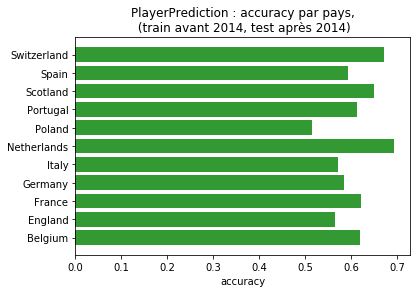

accuracy moyenne :  0.608341549966016


In [47]:
pays = liste_country
stat = liste_accuracy_championnat
y_pos = list(range(len(pays)))
plt.barh(y_pos, stat, align='center', color="green", alpha=0.80)
plt.yticks(y_pos, pays)
plt.xlabel("accuracy")
plt.title("PlayerPrediction : accuracy par pays,\n (train avant 2014, test après 2014)")
plt.figure()
plt.show()
print("accuracy moyenne : ", moyenne(liste_accuracy_championnat))

Accuracy du classifier <b>PlayerPredictionAgg</b> par pays.<br>
* train avec les <b>PlayerPredictions</b> sur les matchs avant la saison 2014/2015 pour chaque pays
* Test sur les matchs après la saison 2014/2015 pour chaque pays

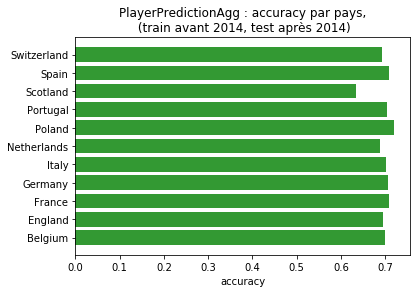

accuracy moyenne :  0.6963517324192896


In [48]:
pays = liste_country_agg
stat = liste_accuracy_championnat_agg
y_pos = list(range(len(pays)))
plt.barh(y_pos, stat, align='center', color="green", alpha=0.80)
plt.yticks(y_pos, pays)
plt.xlabel("accuracy")
plt.title("PlayerPredictionAgg : accuracy par pays,\n (train avant 2014, test après 2014)")
plt.figure()
plt.show()
print("accuracy moyenne : ", moyenne(liste_accuracy_championnat_agg))

## Partie 6 - Analyse

Dans tous les cas, les scores calculés pour chaque équipe (home ou away) pour un <b>predict</b> est basé sur les scores des joueurs de l'équipe pondéré par les scores des joueures présents sur le terrain. 

### PlayerPrediction
<ul>
<li>
Lorsuqu'on fait la prédiction pour une année sur tous les matchs après une une certaine date (<b>date_sep</b>) (mars ou avril) et qu'on l'a entrainé sur les matchs avant cette date, on a une accuracy moyenne par année de <b>70.0%</b>. <br>
C'est cohérent. Car si une équipe fait un bon mercato (estival ou hivernal) et qu'elle a de bon joueurs pour une saison donné, elle fait de bon résultats. Tant que les joueurs sont bons tant que l'équipe gagne (ex: Manchester City), et l'inverse est vrai.
</li>
<li>
Lorsuqu'on fait la prédiction pour l'ensemble des matchs d'un <b>pays</b> après une <b>saison donnée</b> et qu'on l'a entrainé sur les matchs des saisons d'avant, on a une accuracy moyenne par pays de <b>60.0%</b>. <br>
L'accuracy est moins bonne de <b>5%</b>, et ça s'explique par le fait qu'une équipe perd (vend) des joueurs (bon ou mauvais) et achète d'autres (bon ou mauvais) (ex: Leicester City après avoir vendu N'Golo Kanté). 
</li>
</ul>

### PlayerPredictionAgg
<ul>
<li>
Par contre lorsqu'on prend en compte la composition d'une équipe sur une saison (généralement elle ne change pas sur une saison) et qu'on entraine chaque <b>PlayerPrediction</b> sur une saison donnée. <br>
Et on utilise ensuite le modèle <b>PlayerPredictionAgg</b> à qui on les lui donne pour le train. Ensuite on fait le <b>predict</b> en prenant le résultat (classe) majoritaire retourné par les <b>PlayerPredictions</b> entrainé chacun sur une seule saison, on a une <b>accuracy moyenne de  70.0%</b>  <br>
Donc, on se basant sur la composition de l'équipe sur une saison (qui change rarement), on a une meilleure estimation et une meilleure accuracy car il y a une corrélation entre les joueurs qui composent une équipe et cette équipe.
</li>
</ul>

Finalement, on peut dire que la qualité et les performances et le niveau des joueurs d'une équipe nous donnent le niveau d'une équipe.